In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevents column wrapping in Jupyter Notebook
pd.set_option('display.width', 1000)  # Adjusts the display width to fit more columns

In [63]:
def load_data(file_path, label):
    df = pd.read_csv(file_path)
    df['label'] = label
    return df

# Example usage
benign_data = load_data('./BCCC-CIC-IDS-2017/friday_benign.csv', 'benign')
ddos_data = load_data('./BCCC-CIC-IDS-2017/ddos_loit.csv', 'ddos')

# Combine datasets
benign_data['datetime'] = pd.to_datetime(benign_data['timestamp'])
benign_data.set_index('datetime', inplace=True)
benign_data.sort_index(inplace=True)

ddos_data['datetime'] = pd.to_datetime(ddos_data['timestamp'])
ddos_data.set_index('datetime', inplace=True)
ddos_data.sort_index(inplace=True)

In [71]:
bening_subnet = benign_data[(benign_data['dst_ip'].str.startswith('192.168')) & (benign_data['protocol'] == 'TCP')]
ddos_subnet = ddos_data[ddos_data['dst_ip'].str.startswith('192.168')]

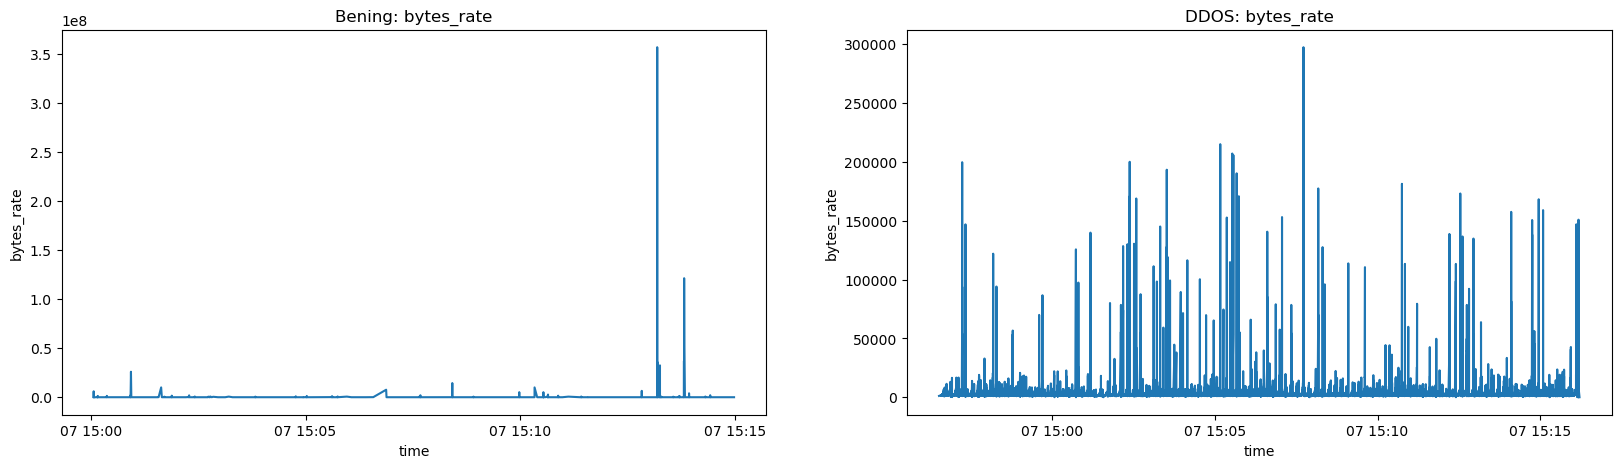

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

bening_window = bening_subnet.between_time('15:00', '15:15')

ax1.plot(bening_window.index, bening_window['bytes_rate'])
ax1.set_title('Bening: bytes_rate')
ax1.set_ylabel('bytes_rate')
ax1.set_xlabel('time')

ax2.plot(ddos_subnet.index, ddos_subnet['bytes_rate'])
ax2.set_title('DDOS: bytes_rate')
ax2.set_ylabel('bytes_rate')
ax2.set_xlabel('time')

plt.show()

In [103]:
features = ['syn_flag_counts', 'rst_flag_counts', 'ack_flag_counts']

In [104]:
bening_subnet_agg = bening_subnet.resample('1s').agg({
    'syn_flag_counts': 'sum',
    'rst_flag_counts': 'sum',
    'ack_flag_counts': 'sum',
})

ddos_subnet_agg = ddos_subnet.resample('1s').agg({
    'syn_flag_counts': 'sum',
    'rst_flag_counts': 'sum',
    'ack_flag_counts': 'sum',
})

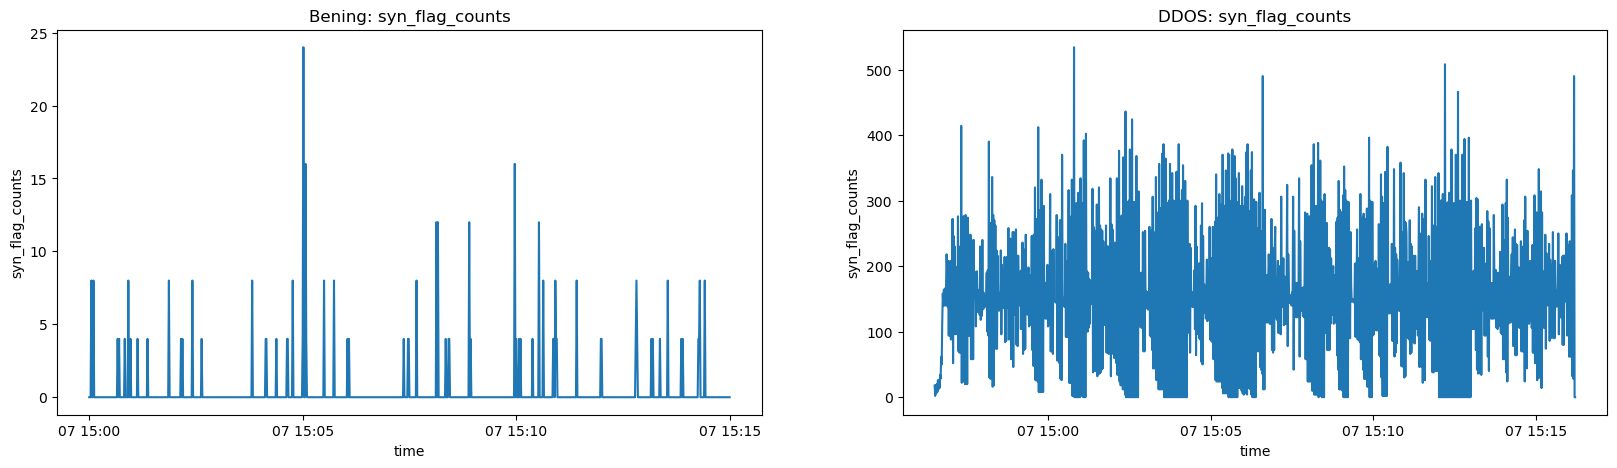

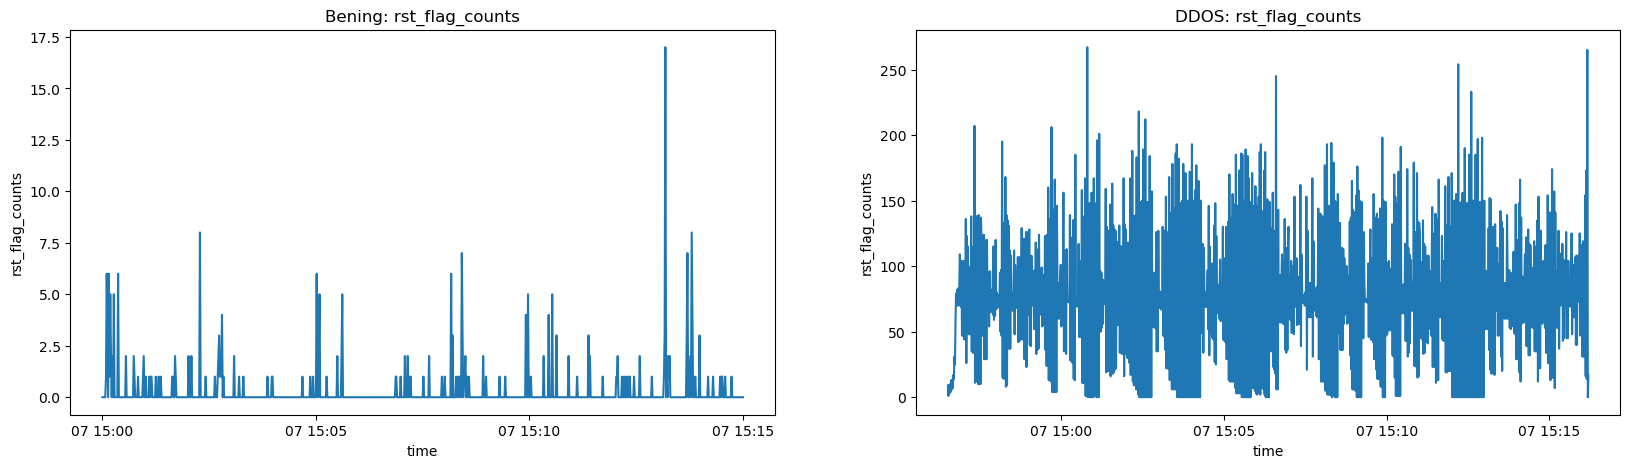

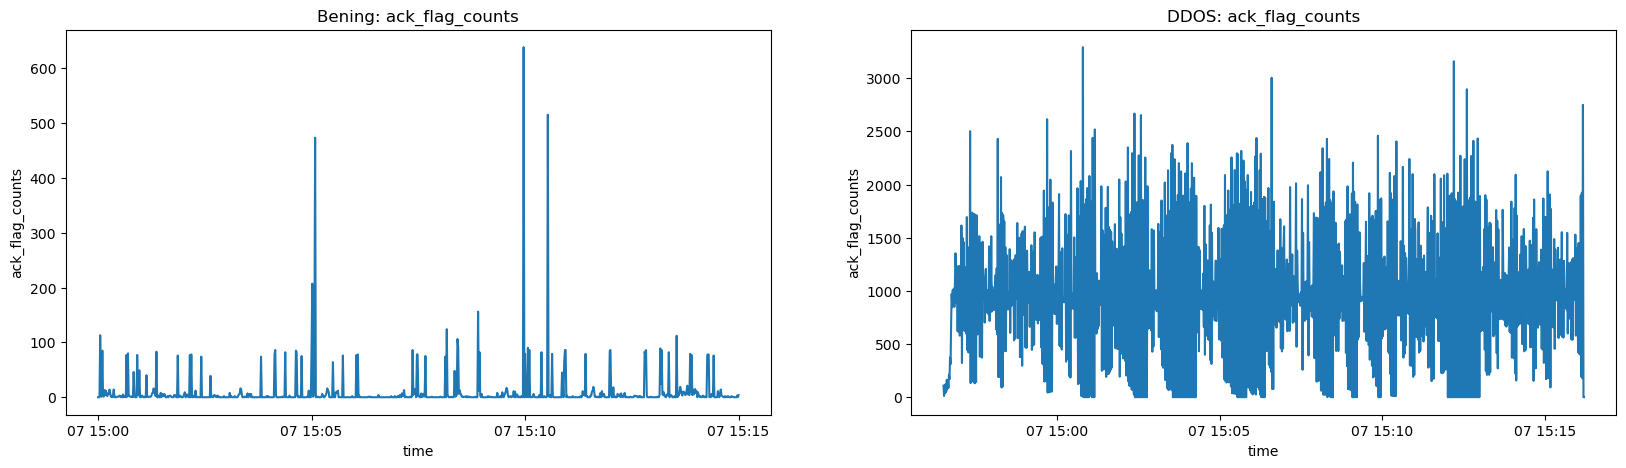

In [105]:

for feature in features:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    bening_window = bening_subnet_agg.between_time('15:00', '15:15')

    ax1.plot(bening_window.index, bening_window[feature])
    ax1.set_title(f'Bening: {feature}')
    ax1.set_ylabel(feature)
    ax1.set_xlabel('time')

    ax2.plot(ddos_subnet_agg.index, ddos_subnet_agg[feature])
    ax2.set_title(f'DDOS: {feature}')
    ax2.set_ylabel(feature)
    ax2.set_xlabel('time')

plt.show()

Now let's try to apply Isolation forrest on these 3 features to detect DDOS.

First, we need to combine both bening and malign data for friday

In [137]:
friday_data = pd.concat([ddos_subnet, bening_subnet], ignore_index=True)
friday_data['datetime'] = pd.to_datetime(friday_data['timestamp'])
friday_data.set_index('datetime', inplace=True)
friday_data.sort_index(inplace=True)

friday_data_agg = friday_data.resample('1s').agg({
    'syn_flag_counts': 'sum',
    'rst_flag_counts': 'sum',
    'ack_flag_counts': 'sum',
    'label': lambda x: 0 if x.eq('benign').all() else 1
})

print(f"There are {friday_data_agg['label'].nunique()} unique labels")

There are 2 unique labels


And apply isolation forest

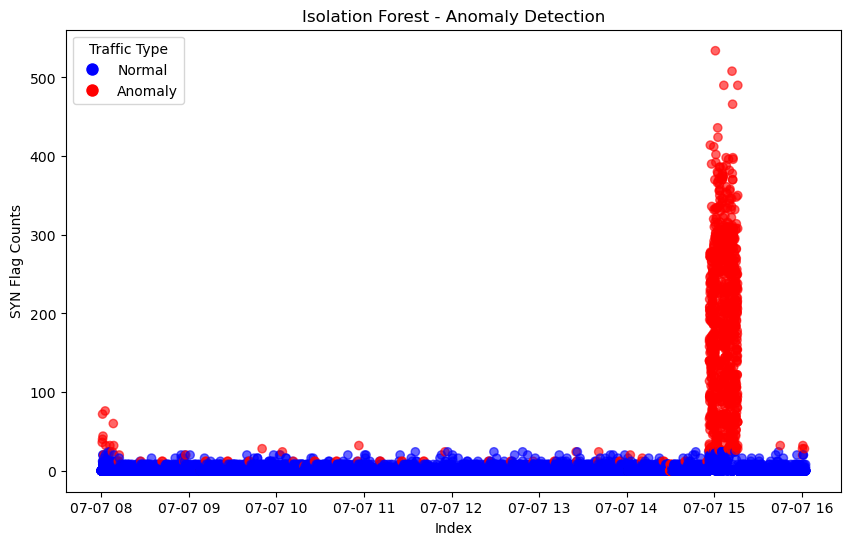

In [190]:
from sklearn.ensemble import IsolationForest
import matplotlib.colors as mcolors

X = friday_data_agg[features]
y = friday_data_agg['label']

model = IsolationForest(contamination=0.04, random_state=42)

anomaly_score = model.fit_predict(X)

X[anomaly_score == -1].index


# Define colors manually
colors = np.where(anomaly_score == -1, 'red', 'blue')  # Red for anomalies, blue for normal

# Create scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X.index, X['syn_flag_counts'], c=colors, alpha=0.6)

# Manually create legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label="Normal"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label="Anomaly")
]

plt.xlabel("Index")
plt.ylabel("SYN Flag Counts")
plt.title("Isolation Forest - Anomaly Detection")
plt.legend(handles=handles, title="Traffic Type")

# Show the plot
plt.show()

In [191]:
y_true = np.where(y == 0, 1, -1)
print("\nClassification Report:\n", classification_report(y_true, anomaly_score, target_names=["Normal", "Anomaly"]))


Classification Report:
               precision    recall  f1-score   support

      Normal       0.86      0.92      0.89      1083
     Anomaly       1.00      0.99      1.00     27889

    accuracy                           0.99     28972
   macro avg       0.93      0.96      0.94     28972
weighted avg       0.99      0.99      0.99     28972



In [189]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

best_f1, best_contamination = 0, None
for c in np.arange(0.01, 0.2, 0.01):  # Test from 1% to 10% anomalies
    model = IsolationForest(contamination=c, random_state=42)
    anomaly_score = model.fit_predict(X)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, anomaly_score, average='binary', pos_label=-1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_contamination = c

print(f"Best contamination: {best_contamination} with F1-score: {best_f1:.4f}")

Best contamination: 0.04 with F1-score: 0.8853


Ok, it's super clear where's the DDOS attack. Aggregation and isolation forest combination should be good enough to track it down. However, it depends on the contamination parameter and might produce a lot of false positives.